In [50]:
import os
import time
import pickle
import math
import copy
import collections
from sortedcontainers import SortedList
from itertools import product,chain
import random

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import catboost as cb
from catboost.utils import get_confusion_matrix
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
import shap

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/Users/marcin/Documents/KBase/KE/KE_KG/src/embeddings'

In [3]:
shap.initjs()

In [4]:
random_seed = 123

print("start")

df_eco_pos = pd.read_csv('../../../IMGVR/link_predict_mg_imgvr_v6_80/virus_host__subtract.tsv', sep=',',  encoding='utf-8',index_col=0)
print(df_eco_pos.head())

start
                                                          X0        X1  \
vOTU:sg_502237__NCBItaxon:bacteria;proteobacter...  0.197663 -0.701570   
vOTU:votu_528368__NCBItaxon:bacteria;proteobact... -0.225672 -0.240224   
vOTU:sg_570586__NCBItaxon:bacteria;proteobacter... -0.162949 -0.203875   
vOTU:sg_299066__NCBItaxon:bacteria;proteobacter...  0.068418  0.042056   
vOTU:sg_820464__NCBItaxon:bacteria;proteobacter...  0.282155  0.127562   

                                                          X2        X3  \
vOTU:sg_502237__NCBItaxon:bacteria;proteobacter...  0.507688 -0.462839   
vOTU:votu_528368__NCBItaxon:bacteria;proteobact... -0.145219 -0.057041   
vOTU:sg_570586__NCBItaxon:bacteria;proteobacter... -0.058121  0.008491   
vOTU:sg_299066__NCBItaxon:bacteria;proteobacter...  0.040437  0.082207   
vOTU:sg_820464__NCBItaxon:bacteria;proteobacter... -0.127085 -0.546924   

                                                          X4        X5  \
vOTU:sg_502237__NCBItaxon:bact

In [5]:
df_eco_neg = pd.read_csv('../../../IMGVR/link_predict_mg_imgvr_v6_80/virus_host_NEGATIVE__subtract.tsv', sep=',',  encoding='utf-8',index_col=0)
print(df_eco_neg.head())

                                                          X0        X1  \
vOTU:sg_502237__NCBItaxon:archaea;euryarchaeota...  0.049910 -0.058778   
vOTU:votu_148127__NCBItaxon:archaea;crenarchaeo...  0.023678 -0.031529   
vOTU:votu_528368__NCBItaxon:bacteria;actinobact... -0.032976  0.017097   
vOTU:votu_140817__NCBItaxon:bacteria;proteobact... -0.040372  0.011660   
vOTU:sg_570586__NCBItaxon:bacteria;firmicutes;b...  0.020545  0.011239   

                                                          X2        X3  \
vOTU:sg_502237__NCBItaxon:archaea;euryarchaeota... -0.000668  0.044152   
vOTU:votu_148127__NCBItaxon:archaea;crenarchaeo...  0.044617 -0.052789   
vOTU:votu_528368__NCBItaxon:bacteria;actinobact... -0.018240  0.009179   
vOTU:votu_140817__NCBItaxon:bacteria;proteobact... -0.027934 -0.055859   
vOTU:sg_570586__NCBItaxon:bacteria;firmicutes;b...  0.001880  0.010259   

                                                          X4        X5  \
vOTU:sg_502237__NCBItaxon:archaea;eu

In [48]:
print(df_eco_pos.shape)
print(df_eco_neg.shape)

(16019, 100)
(40732, 100)


(16019, 100)
(40732, 100)
56751


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
vOTU:sg_502237__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.197663,-0.701570,0.507688,-0.462839,-0.255428,0.138379,-0.234211,-0.420318,-0.773746,-0.100616,...,0.495488,-0.244006,0.144632,0.830460,0.245825,-0.315891,0.296136,-0.082135,0.192938,0.839519
vOTU:votu_528368__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;burkholderiales;burkholderiaceae;burkholderia;,-0.225672,-0.240224,-0.145219,-0.057041,-0.139425,0.138575,-0.204917,-0.129444,0.061226,0.217991,...,-0.298528,-0.554599,0.111604,-0.585058,0.234661,0.675644,-0.187100,0.312165,-0.195910,0.779772
vOTU:sg_570586__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;burkholderiales;burkholderiaceae;burkholderia;,-0.162949,-0.203875,-0.058121,0.008491,-0.210298,0.135375,-0.152385,-0.181810,0.107607,0.253466,...,-0.272978,-0.622227,0.137863,-0.581944,0.216019,0.729676,-0.213522,0.312430,-0.241475,0.760852
vOTU:sg_299066__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;neisseriales;chromobacteriaceae;unclassified_chromobacteriaceae;,0.068418,0.042056,0.040437,0.082207,-0.017668,-0.014541,-0.015937,-0.006701,-0.056715,0.037741,...,0.001248,-0.022067,0.005129,0.008919,-0.014449,-0.008375,0.027580,0.057207,0.001698,0.035129
vOTU:sg_820464__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;alteromonadales;colwelliaceae;colwellia;,0.282155,0.127562,-0.127085,-0.546924,0.127078,-0.202106,0.004857,0.137383,0.414114,-0.217161,...,-0.024208,-0.147444,-0.017565,-0.754603,0.771946,0.273244,0.130519,-0.268326,0.376866,-0.338018


['vOTU:sg_502237__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;',
 'vOTU:votu_528368__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;burkholderiales;burkholderiaceae;burkholderia;',
 'vOTU:sg_570586__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;burkholderiales;burkholderiaceae;burkholderia;',
 'vOTU:sg_299066__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;neisseriales;chromobacteriaceae;unclassified_chromobacteriaceae;',
 'vOTU:sg_820464__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;alteromonadales;colwelliaceae;colwellia;',
 'vOTU:votu_157125__NCBItaxon:bacteria;proteobacteria;deltaproteobacteria;desulfovibrionales;desulfovibrionaceae;unclassified_desulfovibrionaceae;',
 'vOTU:votu_122152__NCBItaxon:bacteria;firmicutes;bacilli;lactobacillales;enterococcaceae;unclassified_enterococcaceae;',
 'vOTU:sg_564732__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pasteurellales;pasteurellaceae;unclassified

In [23]:
df_eco_test = pd.read_csv('../../../IMGVR/link_predict_mg_imgvr_v6_80/virus_host_TEST__subtract.tsv', sep=',',  encoding='utf-8', index_col=0)
print(df_eco_test.head())

                                                          X0        X1  \
vOTU:sg_755331__NCBItaxon:bacteria;proteobacter...  0.238119 -0.696437   
vOTU:sg_825059__NCBItaxon:bacteria;proteobacter...  0.204592 -0.642414   
vOTU:votu_438124__NCBItaxon:bacteria;proteobact...  0.187724 -0.678285   
vOTU:sg_926020__NCBItaxon:bacteria;proteobacter...  0.154156 -0.640036   
vOTU:sg_926413__NCBItaxon:bacteria;proteobacter...  0.147559 -0.658812   

                                                          X2        X3  \
vOTU:sg_755331__NCBItaxon:bacteria;proteobacter...  0.515216 -0.434360   
vOTU:sg_825059__NCBItaxon:bacteria;proteobacter...  0.535036 -0.435961   
vOTU:votu_438124__NCBItaxon:bacteria;proteobact...  0.534748 -0.524344   
vOTU:sg_926020__NCBItaxon:bacteria;proteobacter...  0.542870 -0.446300   
vOTU:sg_926413__NCBItaxon:bacteria;proteobacter...  0.573603 -0.488984   

                                                          X4        X5  \
vOTU:sg_755331__NCBItaxon:bacteria;p

In [49]:
df_eco_test.shape

(5801, 100)

In [96]:
#generate random 2x set of negative examples
randomlist = random.sample(range(0, df_eco_neg.shape[0]), df_eco_test.shape[0]*2)
print(type(randomlist))
print(len(randomlist))
fulllist = list(range(0, df_eco_neg.shape[0]))
print(type(fulllist))
print(len(fulllist))

#selectpart = [fulllist[i] for fulllist not in randomlist]
selectpart = list(set(fulllist) - set(randomlist))
print(len(selectpart))
#partlist = [fulllist[i] for i in fulllist and i not in randomlist]
#partlist = [x for x, y in zip(fulllist, randomlist) if y]
partlist = [ fulllist[index] for index in selectpart ]
print(len(partlist))

#fulllist = fulllist[~randomlist]
#for i in randomlist:
#    fulllist = fulllist.remove(i)
    
print(df_eco_neg.shape)

<class 'list'>
11602
<class 'list'>
40732
29130
29130
(40732, 100)


In [99]:
df_eco_neg_part1 = df_eco_neg.iloc[randomlist]
df_eco_neg_part2 = df_eco_neg.iloc[partlist]

df_eco_total_train = pd.concat([df_eco_pos, df_eco_neg_part2])
print(df_eco_pos.shape)
print(df_eco_neg.shape)
print(df_eco_neg_part1.shape)
print(df_eco_neg_part2.shape)
print(df_eco_total_train.shape)
pos_neg_labels = ([1] * df_eco_pos.shape[0]) + ([0] * df_eco_neg_part2.shape[0])#df_eco_neg.shape[0] - df_eco_test.shape[0]*2 ) )

print(len(pos_neg_labels))
#df_eco_total_train = df_eco_pos
df_eco_total_train.head()

(16019, 100)
(40732, 100)
(11602, 100)
(29130, 100)
(45149, 100)
45149


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
vOTU:sg_502237__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.197663,-0.701570,0.507688,-0.462839,-0.255428,0.138379,-0.234211,-0.420318,-0.773746,-0.100616,...,0.495488,-0.244006,0.144632,0.830460,0.245825,-0.315891,0.296136,-0.082135,0.192938,0.839519
vOTU:votu_528368__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;burkholderiales;burkholderiaceae;burkholderia;,-0.225672,-0.240224,-0.145219,-0.057041,-0.139425,0.138575,-0.204917,-0.129444,0.061226,0.217991,...,-0.298528,-0.554599,0.111604,-0.585058,0.234661,0.675644,-0.187100,0.312165,-0.195910,0.779772
vOTU:sg_570586__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;burkholderiales;burkholderiaceae;burkholderia;,-0.162949,-0.203875,-0.058121,0.008491,-0.210298,0.135375,-0.152385,-0.181810,0.107607,0.253466,...,-0.272978,-0.622227,0.137863,-0.581944,0.216019,0.729676,-0.213522,0.312430,-0.241475,0.760852
vOTU:sg_299066__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;neisseriales;chromobacteriaceae;unclassified_chromobacteriaceae;,0.068418,0.042056,0.040437,0.082207,-0.017668,-0.014541,-0.015937,-0.006701,-0.056715,0.037741,...,0.001248,-0.022067,0.005129,0.008919,-0.014449,-0.008375,0.027580,0.057207,0.001698,0.035129
vOTU:sg_820464__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;alteromonadales;colwelliaceae;colwellia;,0.282155,0.127562,-0.127085,-0.546924,0.127078,-0.202106,0.004857,0.137383,0.414114,-0.217161,...,-0.024208,-0.147444,-0.017565,-0.754603,0.771946,0.273244,0.130519,-0.268326,0.376866,-0.338018


In [100]:
df_eco_total_test = pd.concat([df_eco_test, df_eco_neg_part1])
print(df_eco_pos.shape)
print(df_eco_neg.shape)
print(df_eco_neg_part1.shape)
print(df_eco_neg_part2.shape)
print(df_eco_total_test.shape)
pos_neg_labels_test = ([1] * df_eco_test.shape[0]) + ([0] * (df_eco_neg_part1.shape[0]) )

print(len(pos_neg_labels_test))
#df_eco_total_train = df_eco_pos
df_eco_total_test.head()

(16019, 100)
(40732, 100)
(11602, 100)
(29130, 100)
(17403, 100)
17403


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
vOTU:sg_755331__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.238119,-0.696437,0.515216,-0.434360,-0.253592,0.147709,-0.226338,-0.451251,-0.708751,-0.130126,...,0.535007,-0.256412,0.164539,0.800338,0.178276,-0.352725,0.280629,-0.078864,0.196375,0.876490
vOTU:sg_825059__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.204592,-0.642414,0.535036,-0.435961,-0.273351,0.200047,-0.272774,-0.434568,-0.733573,-0.114966,...,0.511180,-0.237398,0.157344,0.784374,0.180461,-0.314764,0.317369,-0.043205,0.146176,0.876627
vOTU:votu_438124__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.187724,-0.678285,0.534748,-0.524344,-0.295113,0.127922,-0.189630,-0.448108,-0.706525,-0.141666,...,0.498043,-0.277030,0.134430,0.812889,0.178546,-0.264205,0.291058,-0.114506,0.175157,0.805758
vOTU:sg_926020__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.154156,-0.640036,0.542870,-0.446300,-0.290183,0.164678,-0.179652,-0.487002,-0.702092,-0.163919,...,0.443376,-0.257567,0.138700,0.857497,0.239879,-0.348866,0.270446,-0.047632,0.109873,0.868841
vOTU:sg_926413__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.147559,-0.658812,0.573603,-0.488984,-0.263266,0.209143,-0.244319,-0.416670,-0.766712,-0.141178,...,0.495739,-0.269803,0.196559,0.789702,0.260473,-0.325430,0.349046,-0.085831,0.138297,0.854655


In [101]:
#pos_ar_all = list(np.array(df_eco_total_train.index.to_numpy()))
#pos_ar_all

In [102]:
#pos_ar_all_labels = [i.split('__', 1)[0] for i in pos_ar_all]

In [103]:
##df_eco_test_pos_neg = pd.read_csv('../../../IMGVR/link_predict_mg_imgvr_OPT_v5_80/virus_host_TEST__subtract_pos_neg.tsv', sep='\t',  encoding='utf-8')
##df_eco_test_pos_neg.index = df_eco_test.index

#df_eco_test_pos_neg = ([1] * df_eco_test.shape[0])
#print(df_eco_test_pos_neg)

##print(df_eco_test['pos_neg_label'].head())

In [105]:
#type(df_eco_test['pos_neg_label'])
#type(df_eco_test_pos_neg)

In [106]:
#print(type(df_eco_test_pos_neg['x'][1]))
#print(type(df_eco_test['pos_neg_label'][1]))

In [107]:
#sum(df_eco_test_pos_neg['x'].subtract(df_eco_test['pos_neg_label']))

In [108]:
os.getcwd()

'/Users/marcin/Documents/KBase/KE/KE_KG/src/embeddings'

In [110]:
#df_eco_test[df_eco_test['pos_neg_label'] == 0]
X_test = df_eco_total_test#.drop('pos_neg_label', 1)
y_test = pos_neg_labels_test#df_eco_test['pos_neg_label']
print(df_eco_total_test.shape)
print(X_test.shape)

(17403, 100)
(17403, 100)


In [112]:
X_test.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
vOTU:sg_755331__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.238119,-0.696437,0.515216,-0.434360,-0.253592,0.147709,-0.226338,-0.451251,-0.708751,-0.130126,...,0.535007,-0.256412,0.164539,0.800338,0.178276,-0.352725,0.280629,-0.078864,0.196375,0.876490
vOTU:sg_825059__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.204592,-0.642414,0.535036,-0.435961,-0.273351,0.200047,-0.272774,-0.434568,-0.733573,-0.114966,...,0.511180,-0.237398,0.157344,0.784374,0.180461,-0.314764,0.317369,-0.043205,0.146176,0.876627
vOTU:votu_438124__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.187724,-0.678285,0.534748,-0.524344,-0.295113,0.127922,-0.189630,-0.448108,-0.706525,-0.141666,...,0.498043,-0.277030,0.134430,0.812889,0.178546,-0.264205,0.291058,-0.114506,0.175157,0.805758
vOTU:sg_926020__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.154156,-0.640036,0.542870,-0.446300,-0.290183,0.164678,-0.179652,-0.487002,-0.702092,-0.163919,...,0.443376,-0.257567,0.138700,0.857497,0.239879,-0.348866,0.270446,-0.047632,0.109873,0.868841
vOTU:sg_926413__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;,0.147559,-0.658812,0.573603,-0.488984,-0.263266,0.209143,-0.244319,-0.416670,-0.766712,-0.141178,...,0.495739,-0.269803,0.196559,0.789702,0.260473,-0.325430,0.349046,-0.085831,0.138297,0.854655


In [113]:
df_eco_test_labels = list(df_eco_total_test.index.values)
df_eco_test_labels = [i.split('__', 1)[0] for i in df_eco_test_labels]
df_eco_test_labels

['vOTU:sg_755331',
 'vOTU:sg_825059',
 'vOTU:votu_438124',
 'vOTU:sg_926020',
 'vOTU:sg_926413',
 'vOTU:sg_866697',
 'vOTU:sg_915521',
 'vOTU:sg_477996',
 'vOTU:sg_673069',
 'vOTU:sg_714739',
 'vOTU:sg_783563',
 'vOTU:sg_775043',
 'vOTU:sg_814080',
 'vOTU:sg_677151',
 'vOTU:sg_779473',
 'vOTU:votu_686623',
 'vOTU:votu_815181',
 'vOTU:sg_788134',
 'vOTU:sg_169781',
 'NCBItaxon:duplodnaviria;heunggongvirae;uroviricota;caudoviricetes;caudovirales;siphoviridae;vieuvirus;',
 'vOTU:sg_073550',
 'vOTU:sg_018321',
 'vOTU:sg_148254',
 'vOTU:sg_161175',
 'vOTU:sg_165966',
 'vOTU:votu_230737',
 'vOTU:sg_754619',
 'vOTU:sg_020059',
 'vOTU:sg_055770',
 'vOTU:sg_156835',
 'vOTU:sg_216060',
 'vOTU:sg_174150',
 'vOTU:sg_081543',
 'vOTU:sg_154394',
 'vOTU:sg_231223',
 'vOTU:sg_052565',
 'vOTU:sg_146874',
 'vOTU:sg_167514',
 'vOTU:votu_022514',
 'vOTU:sg_084222',
 'vOTU:sg_031565',
 'vOTU:sg_167908',
 'vOTU:votu_126303',
 'vOTU:sg_732602',
 'vOTU:sg_089040',
 'vOTU:sg_196917',
 'vOTU:sg_269089',
 'vOTU:

In [114]:
df_eco_total_train.shape

(45149, 100)

In [115]:
df_eco_total_train.describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
count,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,...,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000,45149.000000
mean,-0.008588,-0.000456,0.012854,0.006388,0.007332,0.017773,0.008003,-0.029238,-0.035206,-0.008237,...,-0.003934,-0.000479,-0.015652,0.027097,0.031198,-0.004095,0.002169,0.020549,0.005724,0.022373
std,0.339146,0.348601,0.315886,0.340247,0.333063,0.343521,0.323582,0.347670,0.327605,0.325242,...,0.315676,0.331666,0.321748,0.357468,0.324433,0.325280,0.319183,0.339311,0.327599,0.327229
min,-2.089661,-2.275767,-1.751473,-1.963040,-1.930504,-2.058733,-2.971332,-2.930558,-1.954202,-1.829890,...,-2.007153,-2.237685,-2.318172,-1.983181,-1.948104,-1.894333,-1.992189,-1.882421,-2.175986,-2.435977
25%,-0.125338,-0.103652,-0.077923,-0.089887,-0.084286,-0.076376,-0.074701,-0.157453,-0.130085,-0.121171,...,-0.086528,-0.089170,-0.120248,-0.084244,-0.066047,-0.085964,-0.082394,-0.082687,-0.088908,-0.072934
50%,-0.001649,-0.000260,-0.000120,-0.000660,0.001067,0.005234,0.004211,-0.005965,-0.009722,-0.005465,...,-0.000765,0.001564,-0.004016,0.002150,0.007547,-0.001473,0.000513,0.002836,0.000117,0.004604
75%,0.080226,0.107877,0.095144,0.100491,0.096297,0.139104,0.097821,0.073651,0.060421,0.076370,...,0.098788,0.106261,0.078993,0.136480,0.131038,0.088702,0.086624,0.140111,0.103924,0.118210
max,2.058541,2.253442,2.237620,2.242950,2.037739,1.740365,2.199824,2.296487,2.035049,1.890151,...,1.909972,1.905939,2.033727,2.293831,1.948181,1.944437,1.754772,2.562028,1.751804,1.907545


In [116]:
y = pd.Series(pos_neg_labels)

X = df_eco_total_train
print(len(y))
print(df_eco_total_train.shape)

45149
(45149, 100)


In [117]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_seed) #, random_state=9# The seed was 'chosen' so test and training contain all labels: rn=3,4,8,9
#print("train label deficit:",len(set(y)-set(y_train)),"test label deficit:",len(set(y)-set(y_test)))

#print("shapes "+str(X_train.shape)+"\t"+str(X_test.shape)+"\t"+str(y_train.shape)+"\t"+str(y_test.shape))

train_dataset = Pool(X, y)#Pool(X_train, y_train)
test_dataset = Pool(X_test, y_test)#Pool(X_test, y_test)

input_data_dump = [X, y, X_test, y_test]
pickle.dump(input_data_dump,open("input_data_dump", "wb" ) )

In [118]:
y

0        1
1        1
2        1
3        1
4        1
        ..
45144    0
45145    0
45146    0
45147    0
45148    0
Length: 45149, dtype: int64

In [121]:
modelstart = time.time()

print(f"Starting search at {modelstart}")
cb_model = CatBoostClassifier(
                             loss_function='Logloss',                              
                             #loss_function='MAE',
                             iterations = 500,
                             verbose = 5,
                             learning_rate = 0.1,
                             depth = 3,
                             l2_leaf_reg = 0.5,
                             border_count=32,    
                             random_strength = 1,
                             bagging_temperature = 0.2,
                             #eval_metric='Accuracy',
                             #eval_metric = 'MCC',
                             random_seed = random_seed,
                             od_type = 'Iter',
                             od_wait = 100
)

#grid = {
#        'iterations': [100, 200, 300],
#        'learning_rate': [0.6, 0.8, 1],
#        'depth': [3,4,5],
#        'l2_leaf_reg': [0.1, 1, 2],
#        'ctr_border_count': [10,50,100],
#        'border_count': [10,50,100]
#   
#        #'learning_rate': [0.8],
#        #'depth': [3,4,5],
#       #'l2_leaf_reg': [0.1, 0.5, 1,1.5]
#}

#de %s 6 it 250 le 0.1 lr 1 bc 200 rs 1 bt 0.1

params = {'depth':[4,5,6],
          #'iterations':[50,100,250],
          'learning_rate':[0.001, 0.1, 1], 
          'l2_leaf_reg':[0.1,1,2],
          'border_count':[10,100,200],
          #'random_strength':[0.1, 1, 3],
          'bagging_temperature':[0.001, 0.01, 0.1],#[0.1, 1, 3],
         }

grid_search_result = cb_model.grid_search(params, train_dataset)
#grid_search_result = cb_model.randomized_search(grid, train_dataset)

de = grid_search_result['params']['depth']
it = 500#grid_search_result['params']['iterations']
le = grid_search_result['params']['learning_rate']
lr = grid_search_result['params']['l2_leaf_reg']
bc = grid_search_result['params']['border_count']
rs = 1#grid_search_result['params']['random_strength']
bt = grid_search_result['params']['bagging_temperature']

print(f"Trained grid search in {time.time() - modelstart}s")
print("de %s", str(de), "it", str(it), "le",str(le),"lr",str(lr),"bc",str(bc),"rs",str(rs),"bt",str(bt))
#de %s 6 it 250 le 0.1 lr 1 bc 200 rs 0.1 bt 0.1

Starting search at 1618970160.340373

bestTest = 0.5513410568
bestIteration = 499

0:	loss: 0.5513411	best: 0.5513411 (0)	total: 5.66s	remaining: 22m 49s

bestTest = 0.3961937975
bestIteration = 473

1:	loss: 0.3961938	best: 0.3961938 (1)	total: 11.2s	remaining: 22m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4281054247
bestIteration = 17

2:	loss: 0.4281054	best: 0.3961938 (1)	total: 12.4s	remaining: 16m 34s

bestTest = 0.5513074165
bestIteration = 499

3:	loss: 0.5513074	best: 0.3961938 (1)	total: 18.1s	remaining: 18m 4s

bestTest = 0.3961554543
bestIteration = 499

4:	loss: 0.3961555	best: 0.3961555 (4)	total: 23.8s	remaining: 18m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4253581138
bestIteration = 22

5:	loss: 0.4253581	best: 0.3961555 (4)	total: 25.2s	remaining: 16m 36s

bestTest = 0.5512133923
bestIteration = 499

6:	loss: 0.5512134	best: 0.3961555 (4)	total: 31.3s	remaining: 17m 33s

bestTest = 0.3972515504
bestIteratio

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4253581138
bestIteration = 22

59:	loss: 0.4253581	best: 0.3947342 (22)	total: 4m 50s	remaining: 14m 45s

bestTest = 0.5512133923
bestIteration = 499

60:	loss: 0.5512134	best: 0.3947342 (22)	total: 4m 57s	remaining: 14m 46s

bestTest = 0.3972515504
bestIteration = 437

61:	loss: 0.3972516	best: 0.3947342 (22)	total: 5m 4s	remaining: 14m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4262196945
bestIteration = 31

62:	loss: 0.4262197	best: 0.3947342 (22)	total: 5m 5s	remaining: 14m 34s

bestTest = 0.5419255251
bestIteration = 499

63:	loss: 0.5419255	best: 0.3947342 (22)	total: 5m 12s	remaining: 14m 34s

bestTest = 0.3969984781
bestIteration = 493

64:	loss: 0.3969985	best: 0.3947342 (22)	total: 5m 18s	remaining: 14m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.42587563
bestIteration = 18

65:	loss: 0.4258756	best: 0.3947342 (22)	total: 5m 19s	remaining: 14m 18s

b


bestTest = 0.5358442339
bestIteration = 499

117:	loss: 0.5358442	best: 0.3947342 (22)	total: 10m 54s	remaining: 11m 33s

bestTest = 0.3960267088
bestIteration = 489

118:	loss: 0.3960267	best: 0.3947342 (22)	total: 11m 2s	remaining: 11m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4331843845
bestIteration = 14

119:	loss: 0.4331844	best: 0.3947342 (22)	total: 11m 4s	remaining: 11m 20s

bestTest = 0.5357562172
bestIteration = 499

120:	loss: 0.5357562	best: 0.3947342 (22)	total: 11m 11s	remaining: 11m 17s

bestTest = 0.3986423454
bestIteration = 404

121:	loss: 0.3986423	best: 0.3947342 (22)	total: 11m 19s	remaining: 11m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.429488617
bestIteration = 14

122:	loss: 0.4294886	best: 0.3947342 (22)	total: 11m 21s	remaining: 11m 5s

bestTest = 0.5358478397
bestIteration = 499

123:	loss: 0.5358478	best: 0.3947342 (22)	total: 11m 29s	remaining: 11m 1s
Stopped by overfitting detector  (100 itera

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4339725277
bestIteration = 10

173:	loss: 0.4339725	best: 0.3947342 (22)	total: 16m 2s	remaining: 6m 21s

bestTest = 0.5350270527
bestIteration = 499

174:	loss: 0.5350271	best: 0.3947342 (22)	total: 16m 10s	remaining: 6m 17s

bestTest = 0.3960714767
bestIteration = 433

175:	loss: 0.3960715	best: 0.3947342 (22)	total: 16m 19s	remaining: 6m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.429830566
bestIteration = 12

176:	loss: 0.4298306	best: 0.3947342 (22)	total: 16m 21s	remaining: 6m 5s

bestTest = 0.5352416072
bestIteration = 499

177:	loss: 0.5352416	best: 0.3947342 (22)	total: 16m 29s	remaining: 6m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3970084533
bestIteration = 392

178:	loss: 0.3970085	best: 0.3947342 (22)	total: 16m 39s	remaining: 5m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4285661063
bestIteration = 12

179:	loss: 0.42


bestTest = 0.5350270527
bestIteration = 499

228:	loss: 0.5350271	best: 0.3947342 (22)	total: 22m 6s	remaining: 1m 21s

bestTest = 0.3960714767
bestIteration = 433

229:	loss: 0.3960715	best: 0.3947342 (22)	total: 22m 15s	remaining: 1m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.429830566
bestIteration = 12

230:	loss: 0.4298306	best: 0.3947342 (22)	total: 22m 17s	remaining: 1m 9s

bestTest = 0.5352416072
bestIteration = 499

231:	loss: 0.5352416	best: 0.3947342 (22)	total: 22m 26s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3970084533
bestIteration = 392

232:	loss: 0.3970085	best: 0.3947342 (22)	total: 22m 35s	remaining: 58.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4285661063
bestIteration = 12

233:	loss: 0.4285661	best: 0.3947342 (22)	total: 22m 37s	remaining: 52.2s

bestTest = 0.5295161231
bestIteration = 499

234:	loss: 0.5295161	best: 0.3947342 (22)	total: 22m 46s	remaining: 46.

In [132]:
#de %s 6 it 250 le 0.1 lr 1 bc 200 rs 1 bt 0.1
#de %s 6 it 500 le 0.1 lr 1 bc 10 rs 1 bt 0.001
#de %s 6 it 500 le 0.1 lr 1 bc 10 rs 1 bt 0.001
modelstart = time.time()

print(f"Starting at {modelstart}")
cb_model = CatBoostClassifier(
                             loss_function='Logloss', 
                             eval_metric='Accuracy',
                            #loss_function='MAE',
                             iterations = it,
                             verbose = 5,
                             learning_rate = le,
                             depth = de,
                             l2_leaf_reg = lr,
                             border_count = bc,
                             random_strength = rs,
                             bagging_temperature = bt,
                             #eval_metric = 'MCC',
                             random_seed = random_seed,
                             #bagging_temperature = 0.2,
                             #od_type = 'Iter',
                             #od_wait = 100
)

cbmf = cb_model.fit(X, y)
print(f"Trained in {time.time() - modelstart}s")

Starting at 1618972688.7383838
0:	learn: 0.7954329	total: 64.7ms	remaining: 32.3s
5:	learn: 0.8027199	total: 157ms	remaining: 12.9s
10:	learn: 0.8088994	total: 227ms	remaining: 10.1s
15:	learn: 0.8130856	total: 314ms	remaining: 9.49s
20:	learn: 0.8171167	total: 394ms	remaining: 8.99s
25:	learn: 0.8213914	total: 464ms	remaining: 8.46s
30:	learn: 0.8252674	total: 543ms	remaining: 8.22s
35:	learn: 0.8282354	total: 611ms	remaining: 7.88s
40:	learn: 0.8315134	total: 677ms	remaining: 7.58s
45:	learn: 0.8347472	total: 748ms	remaining: 7.38s
50:	learn: 0.8362976	total: 832ms	remaining: 7.33s
55:	learn: 0.8379809	total: 925ms	remaining: 7.33s
60:	learn: 0.8395313	total: 1.02s	remaining: 7.36s
65:	learn: 0.8405945	total: 1.09s	remaining: 7.19s
70:	learn: 0.8419013	total: 1.17s	remaining: 7.06s
75:	learn: 0.8428980	total: 1.24s	remaining: 6.94s
80:	learn: 0.8438061	total: 1.31s	remaining: 6.8s
85:	learn: 0.8448249	total: 1.38s	remaining: 6.66s
90:	learn: 0.8463089	total: 1.47s	remaining: 6.59s
95

In [133]:
pred_train = cb_model.predict(X)#, prediction_type='RawFormulaVal')

In [145]:
pred_test = cb_model.predict(X_test)#, prediction_type='RawFormulaVal')s

In [135]:
pred_test

array([1, 1, 1, ..., 0, 0, 1])

In [136]:
len(pred_test[pred_test == 1])

3988

In [137]:
print(len(y_test))
sum(y_test - pred_test)

17403


1813

In [138]:
precision_recall_fscore_support(y_test, pred_test, average='binary')

(0.7512537612838516, 0.5164626788484744, 0.6121156400040862, None)

In [139]:
print(average_precision_score(y_test, pred_test))
print(f1_score(y_test, pred_test))

0.5491736370981588
0.6121156400040862


In [140]:
confusion_matrix(y_test, pred_test)

array([[10610,   992],
       [ 2805,  2996]])

In [141]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
#precision
print(tp/(tp+fp))
#recall
print(tp/(tp+fn))

0.7512537612838516
0.5164626788484744


In [192]:
explainer_model = shap.TreeExplainer(cb_model)
shap_values = explainer_model.shap_values(X_test)

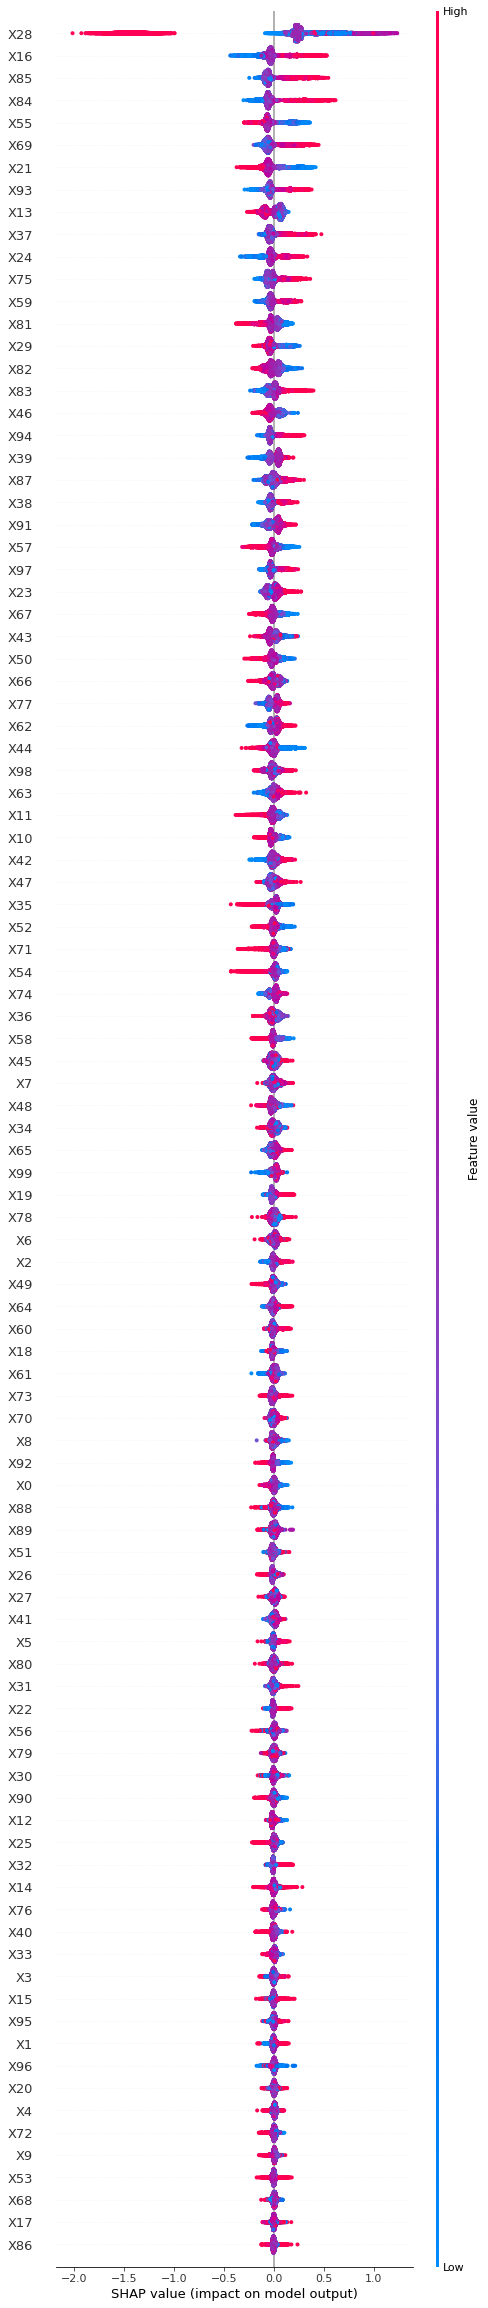

In [193]:
shap.summary_plot(shap_values, X_test, feature_names = cb_model.feature_names_,class_names=cb_model.classes_,max_display=X_test.shape[1])

In [142]:
df_eco_new = pd.read_csv('../../../IMGVR/link_predict_mg_imgvr_v6_80/virus_host_NEW__subtract.tsv', sep=',',  encoding='utf-8',index_col=0)
print(df_eco_new.head())

                                                          X0        X1  \
vOTU:sg_104415__NCBItaxon:bacteria;proteobacter...  0.145634 -0.723811   
vOTU:sg_104415__NCBItaxon:bacteria;proteobacter... -0.050102 -0.016554   
vOTU:sg_104415__NCBItaxon:bacteria;proteobacter... -0.234570 -0.275352   
vOTU:sg_104415__NCBItaxon:bacteria;proteobacter... -0.049026 -0.001615   
vOTU:sg_104415__NCBItaxon:bacteria;proteobacter... -0.014074 -0.034619   

                                                          X2        X3  \
vOTU:sg_104415__NCBItaxon:bacteria;proteobacter...  0.539215 -0.493914   
vOTU:sg_104415__NCBItaxon:bacteria;proteobacter...  0.046541  0.026962   
vOTU:sg_104415__NCBItaxon:bacteria;proteobacter... -0.104460 -0.049852   
vOTU:sg_104415__NCBItaxon:bacteria;proteobacter...  0.042903 -0.016844   
vOTU:sg_104415__NCBItaxon:bacteria;proteobacter...  0.048798  0.020822   

                                                          X4        X5  \
vOTU:sg_104415__NCBItaxon:bacteria;p

In [144]:
pred_new = cb_model.predict(df_eco_new)

In [148]:
df_eco_new.index[pred_new==1]

Index(['vOTU:sg_104415__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;moraxellaceae;acinetobacter;',
       'vOTU:sg_104415__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;burkholderiales;burkholderiaceae;burkholderia;',
       'vOTU:sg_104415__NCBItaxon:bacteria;firmicutes;bacilli;lactobacillales;enterococcaceae;unclassified_enterococcaceae;',
       'vOTU:sg_104415__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;enterobacterales;enterobacteriaceae;unclassified_enterobacteriaceae;',
       'vOTU:sg_104415__NCBItaxon:bacteria;firmicutes;bacilli;lactobacillales;lactobacillaceae;unclassified_lactobacillaceae;',
       'vOTU:sg_104415__NCBItaxon:bacteria;firmicutes;bacilli;lactobacillales;streptococcaceae;unclassified_streptococcaceae;',
       'vOTU:sg_104415__NCBItaxon:bacteria;proteobacteria;betaproteobacteria;neisseriales;neisseriaceae;neisseria;',
       'vOTU:sg_104415__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;pseudom

In [149]:
pred_proba_new = cb_model.predict_proba(df_eco_new)

In [153]:
pred_proba_new[pred_proba_new > 0.98]

array([0.98679054, 0.99020459, 0.98011628, 0.98532249, 0.98084772,
       0.9890376 , 0.98446729, 0.98578474, 0.98794886, 0.9827445 ,
       0.9869022 , 0.98385895, 0.98736792, 0.98650494, 0.98542573])

In [181]:
print(type(df_eco_new.index))
print(type(pred_proba_new))
print(pred_proba_new.shape)
pred_proba_new[:,1][pred_proba_new[:,1] > 0.98]

<class 'pandas.core.indexes.base.Index'>
<class 'numpy.ndarray'>
(6222, 2)


array([0.98679054, 0.99020459, 0.98011628, 0.98532249, 0.98084772,
       0.9890376 , 0.98446729, 0.98578474, 0.98794886, 0.9827445 ,
       0.9869022 , 0.98385895, 0.98736792, 0.98650494, 0.98542573])

In [190]:
df_eco_new_index = np.array(df_eco_new.index)
print(len(df_eco_new_index))
df_eco_new_index_S = pd.Series(df_eco_new_index)
df_eco_new_index_S.index = df_eco_new.index

pred_proba_new_np = pd.Series(pred_proba_new[:,1])
pred_proba_new_np.index = df_eco_new.index


select_bool = pred_proba_new_np > 0.98

select_index = np.where(select_bool)[0]

print(select_index)
print(pred_proba_new_np[select_index].sort_values(ascending=False))
#top_pred_df = pd.concat([df_eco_new_index_S[select_index], pred_proba_new_np[select_index]])
#top_pred_df

6222
[   8   16   98  118  120  356 2082 2090 2192 2194 2430 4156 4164 4266
 4504]
vOTU:sg_104415__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;pseudomonadaceae;pseudomonas;                           0.990205
vOTU:sg_104415__NCBItaxon:bacteria;firmicutes;clostridia;clostridiales;ruminococcaceae;faecalibacterium;                                      0.989038
vOTU:sg_139345__NCBItaxon:bacteria;firmicutes;bacilli;lactobacillales;streptococcaceae;streptococcus;                                         0.987949
vOTU:sg_927184__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;pseudomonadales;pseudomonadaceae;pseudomonas;                           0.987368
vOTU:sg_139345__NCBItaxon:bacteria;firmicutes;clostridia;clostridiales;ruminococcaceae;faecalibacterium;                                      0.986902
vOTU:sg_104415__NCBItaxon:bacteria;proteobacteria;gammaproteobacteria;enterobacterales;enterobacteriaceae;unclassified_enterobacteriaceae;    0.986791
vOTU:sg_927